# Social Media Analytics POC - Twitter
-----------------------------------------

Twitter is a worldwide database of human sentiment. About 500 million new tweets go out per day [(source)](http://www.internetlivestats.com/twitter-statistics/). The ability to stream, parse and understand Twitter data at large scale has huge implications for marketing, humanitarian efforts, social sciences and many other ventures. The combination of Twitter and deep-learning methods like sentimant analysis has lead to platforms which mine twitter data to provide in-depth analytics for businesses. It is even possible to track the entire emotional state of the world at any given time! As Python users, we have access to easy-to-use tools to directly communicate with Twitter's data, and this puts a world of data right at our fingertips.


To make its data available, Twitter hosts a Representational State Transfer Application Programing Interface (REST API). The API dictates what data twitter makes available, and REST refers to an architectural design pattern for building scalable web services. 

## Environment Setup

There are several Python interfaces to Twitter's REST API. Here we will use `tweepy`. And `Matplotlib` for plotting charts.

In [ ]:
# Import pylab, change default matplotlib settings
%pylab inline

rcParams["figure.figsize"] = (11, 8) #<-- Large default figures

# Plot text elements
rcParams['axes.labelsize'] = 17
rcParams['axes.titlesize'] = 17
rcParams['xtick.labelsize'] = 15
rcParams['ytick.labelsize'] = 15

In [5]:
# Setup some personal parameters
%run config.py

In [4]:
import tweepy

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth)

#public_tweets = api.home_timeline()
#for (idx, tweet) in enumerate(public_tweets[0:3]): #First 3 tweets in my public feed
#    print('TWEET ', idx, ' --> ' , tweet.text)

## Search with **HSBC** keyword  

Before going forward, we can try doing some search query through Twitter's webpage
https://twitter.com/search-advanced

Twitter employs a special query language. For example, the query "HSBC?" will return tweets that contain the word *HSBC*. 

Let's search for 100 tweets about HSBC, phrased as a question.

In [5]:
results = api.search(q='HSBC', count=100)
print(type(results))

<class 'tweepy.models.SearchResults'>


Here we save the results to a file in order to continue our studying without accessing Twitter.

In [6]:
import pickle
with open('twitter_query_resule.pkl', 'wb') as output:
    pickle.dump(results, output, pickle.HIGHEST_PROTOCOL)

In [7]:
# Read query result from file
import pickle
with open ('twitter_query_resule.pkl', 'rb') as input:
    results = pickle.load(input)
    print(type(results))
    
with open ('twitter_query_resule_json.pkl', 'rb') as input:
    results_json_str = pickle.load(input)
    print(type(results_json_str))    

<class 'tweepy.models.SearchResults'>
<class 'str'>


The result is a `tweepy.models.SearchResults` class (see other tweepy's models [here](https://github.com/tweepy/tweepy/blob/master/tweepy/models.py).
). Rather than just dumping a bunch of JSON data on us, the `tweepy api` has decoded the JSON and put it into a more pythonic object. 

### Study the SearchResult

We may need to look at below attributes in a tweet.
* created_at: timestamp of tweet being created
* user: the author's full profile
  * followers_count - influence
* text: the text of the tweet itself
* favorite_count, retweet_count: the number of favourites and retweets
* favorited, retweeted: boolean stating whether the authenticated user (me) have favourited or retweeted this tweet
* lang: acronym for the language
* id: the tweet identifier
* place, coordinates, geo: geo-location information if afailable
* entities: list of entities like URLs, @-mentions, hashtags and symbols
* in_reply_to_user_id: user identifier if the tweet is a reply to a specific user
* in_reply_to_status_id: status identifier id the tweet is a reply to a specific status


In [ ]:
c = results[0]
print(type(c))
print('created_atCREATED: ', c.created_at, '\n', c.text)
print(type(c.entities["user_mentions"]))


Search will return 100 records as a batch, more return need to investigate next search.

In [8]:
len(results)

100

## Getting data from Twitter streaming API

A seperated program is prepared as a stream listener to receive tweets and write to a JSON format file.

The file `data/stream_HSBC_20161019.json` contains tweets which mentioned HSBC during 8-hour streaming in *2016-10-19*.

In [ ]:
import json
with open('data/stream_HSBC_20161020.json', 'r') as f:
    line = f.readline()
    tweet = json.loads(line)
    print(json.dumps(tweet, indent=4))

## Preliminary text analytics on Tweets

NLTK is a leading platform for building Python programs to work with human language data. Here we'll use this package to start our exploration on text mining. [(NLTK Homepage)](http://www.nltk.org/index.html)

A local NLTK data was downloaded and shared to all users in `/spare/app/share/nltk_data`

In [43]:
# Test nltk_data
from nltk.corpus import brown
brown.words()

['The', 'Fulton', 'County', 'Grand', 'Jury', 'said', ...]

### Tokenise Tweet text

In `NLTK` there's a built-in tokenizer for Tweeter, `TweetTokenizer`.

In [9]:
from nltk.tokenize import TweetTokenizer

tknzr = TweetTokenizer()
print(tknzr.tokenize(tweet['text']))

['“', 'Higher', 'Gold', 'Prices', '”', 'On', 'Global', 'Trade', 'Slowdown', '–', 'HSBC', 'https://t.co/RJQsbLujfe', '@RPoulden', '@WishboneGoldplc', '@JCharrison', '@damsonprcity']


### Term Frequencies

As the beginning we'll analyze the term frequencies to extract meaningful terms from our tweets.

[('#HSBC', 515), ('#FLASHBACKFRIDAY', 107), ('#HILLARYCLINTON', 93), ('#CREDIT', 80), ('#STANDUPTOCANCER', 76)]


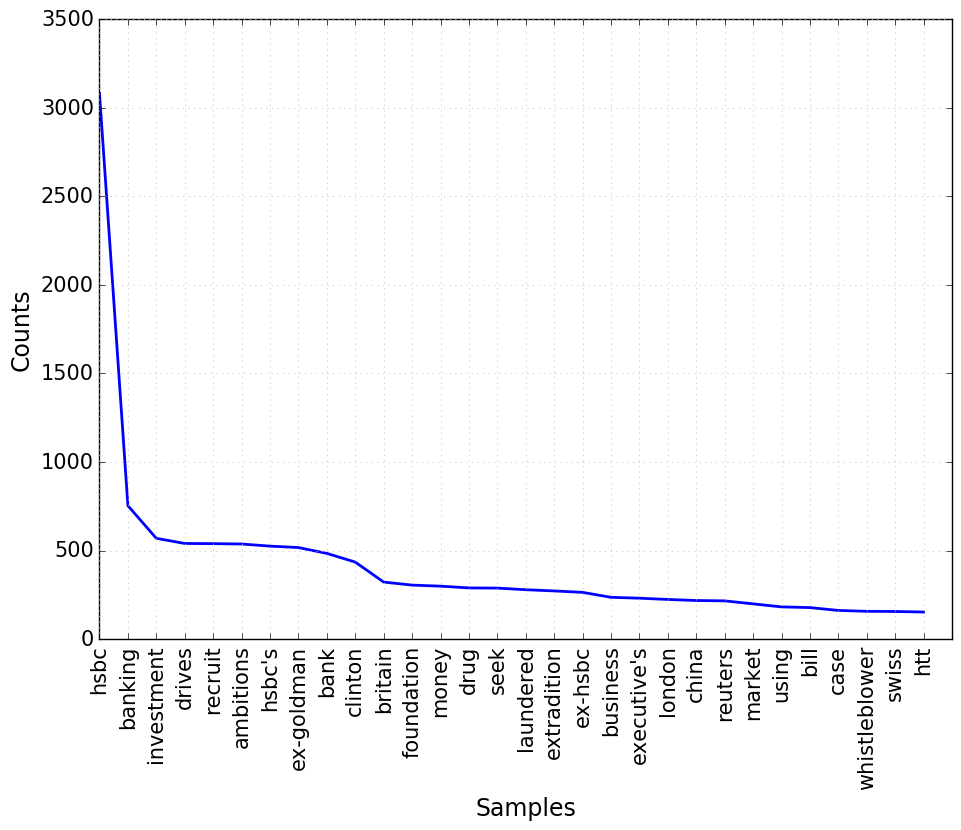

In [69]:
import operator
import json
import nltk
from collections import Counter
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords

tknzr = TweetTokenizer()

# NLTK's default English stopwords
default_stopwords = nltk.corpus.stopwords.words('english')

custom_stopwords = open('stopwords.txt','r').read().splitlines();

stopwords = default_stopwords + custom_stopwords

with open('data/stream_HSBC_20161020.json', 'r') as f:
    count_all = Counter()
    count_hash = Counter()
    count_term = Counter()
    full_terms_only = []
    for line in f:
        if len(line) > 1:
            try:
                tweet = json.loads(line)
                tokens = tknzr.tokenize(tweet['text'])
                terms_all = [term for term in tokens]
                # Count hashtags only
                terms_hash = [term.upper() for term in tokens
                              if term.startswith('#') and
                              not operator.eq(len(term), 1)]
                
                terms_stop = [term.lower() for term in tokens
                              if term.lower() not in stopwords]
                # Count terms only
                terms_only = [term.lower() for term in tokens
                              if term.lower() not in stopwords and
                              not term.startswith(('#', '@')) and
                              not term.isnumeric() and
                              operator.gt(len(term), 1) and
                              operator.lt(len(term), 32)]
                count_all.update(terms_all)
                count_hash.update(terms_hash)
                count_term.update(terms_only)
                full_terms_only.extend(terms_only)
            except ValueError:
                print("Decoding JSON has failed", len(line))
    # Print the first 5 most frequent words
    print(count_hash.most_common(5))
            
tweet_text = nltk.Text(full_terms_only)
fd = nltk.FreqDist(nltk.Text(full_terms_only))
fd.plot(30, cumulative=False)

While some frequent terms represent a clear topic, more often than not simple term frequencies don't give us a deep explanation of what the text is about. To put things in context, let's consider sequences of two terms (a.k.a. bigram).

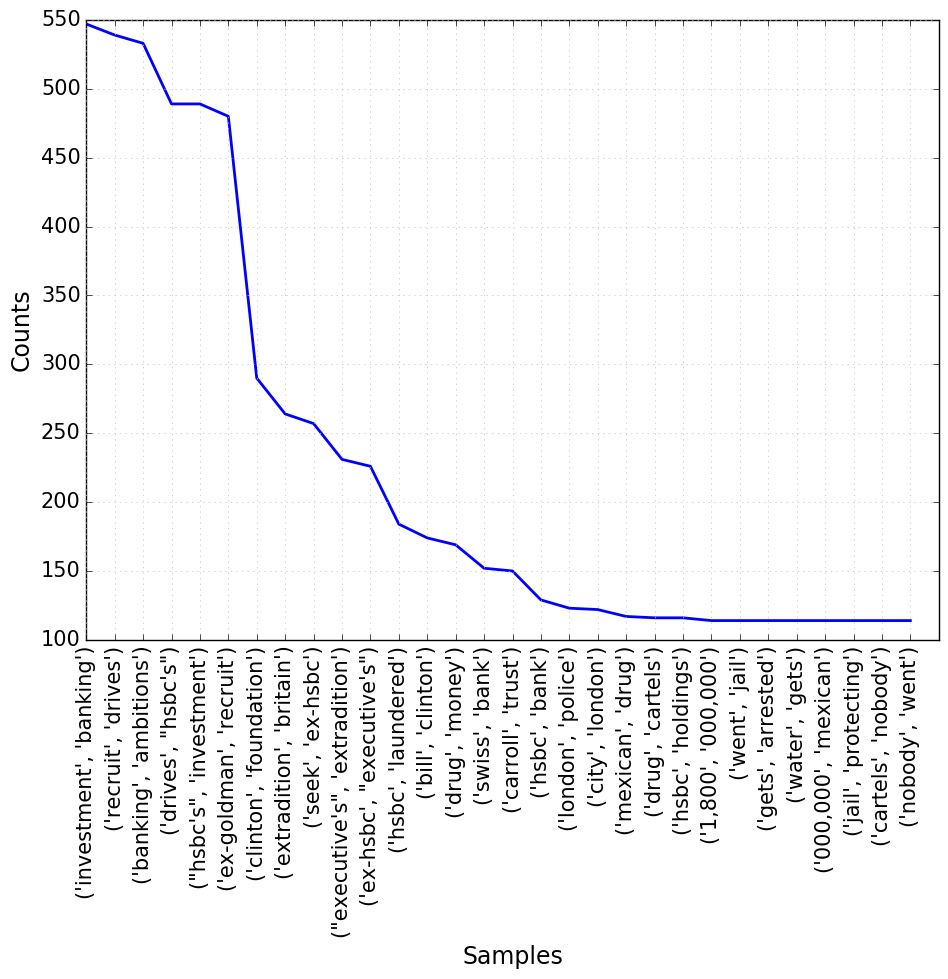

In [7]:
fd = nltk.FreqDist(nltk.bigrams(full_terms_only))
fd.plot(30, cumulative=False)


### Word cloud visualization

Word Cloud chart is usually hired to visualize the term frequencies as below.

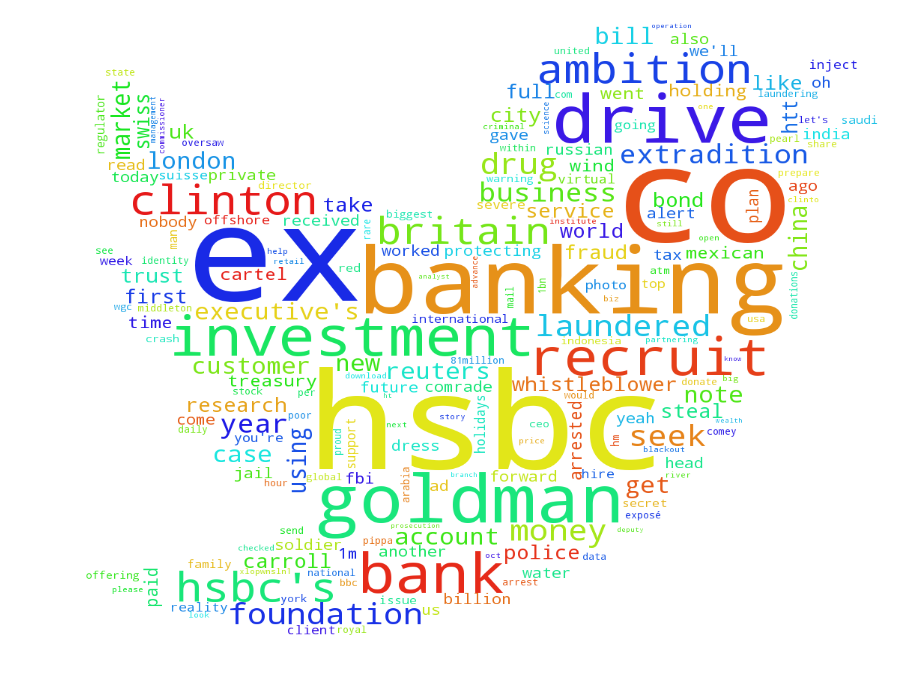

In [8]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

from wordcloud import WordCloud

stopwords = set()
stopwords.add("https")

# read the mask image
twitter_mask = np.array(Image.open("images/twitter_mark.png"))

wc = WordCloud(background_color="white", max_words=200, mask=twitter_mask,
               stopwords=stopwords)

wc.generate(' '.join(full_terms_only))

# show
plt.imshow(wc, aspect='auto')
plt.axis("off")
#plt.figure()
#plt.imshow(twitter_mask, cmap=plt.cm.gray)
#plt.axis("off")
plt.show()


## Sentiment analysis

Sentiment analysis has a wide appeal as providing information about the subjective dimentsion of texts. It can be regarded as a **classification** technique, either binary (polarity classification into positive/negative) or multi-class categorization (e.g. positive/neutral/negative).

Most approaches use a sentiment lexicon as a conponent (sometimes the only component). Lexicons can either be general purpose, or extrated from a suitable corpus, such as movie reviews with explicit ranking information.

We'll start the sentiment analysis from supervised classification. **Classification** is the task of choosing the correct **class label** from a given input. In basic classification tasks, each input is considered in isolation from all other inputs, and the set of labels is defined in advance.  
  
A classifier is call **supervised** if it is built based on traning corpora containing the correct label for each input. The framework used by supervised classification is show as below.

<img src="images/supervised-classification.png" title="supervised-classification" alt="supervised-classification.png" />

### Training the sentiment model

The purpose of this model is to be able to automatically classify a tweet as a positive or negative tweet sentiment wise. Below figure demonstrates the procedure to train a sentiment model by using `NLTK`.
<img src="images/nltk_classifier.png">

#### Training data set
NLTK's Twitter corpus currently contains a sample of 20k Tweets (named 'twitter_samples') retrieved from the Twitter Streaming API, together with another 10k which are divided according to sentiment into negative and positive. We'll use those as our training data sets.

In [12]:
from nltk.corpus import twitter_samples

twitter_samples.fileids()

['negative_tweets.json', 'positive_tweets.json', 'tweets.20150430-223406.json']

In [13]:
strings = twitter_samples.strings('tweets.20150430-223406.json')
for string in strings[:5]:
    print(string)

RT @KirkKus: Indirect cost of the UK being in the EU is estimated to be costing Britain £170 billion per year! #BetterOffOut #UKIP
VIDEO: Sturgeon on post-election deals http://t.co/BTJwrpbmOY
RT @LabourEoin: The economy was growing 3 times faster on the day David Cameron became Prime Minister than it is today.. #BBCqt http://t.co…
RT @GregLauder: the UKIP east lothian candidate looks about 16 and still has an msn addy http://t.co/7eIU0c5Fm1
RT @thesundaypeople: UKIP's housing spokesman rakes in £800k in housing benefit from migrants.  http://t.co/GVwb9Rcb4w http://t.co/c1AZxcLh…


We take both of positive and negative tweets and create a single list of tuples each containing two elements. First element is an array containing the words and second element is the type of sentiment. We get rid of the words smaller than 2 characters and we use lowercase for everything

In [14]:
from nltk.tokenize import TweetTokenizer

tknzr = TweetTokenizer()
pos_tweets = []
neg_tweets = []
for text in twitter_samples.strings('positive_tweets.json'):
    pos_tweets.append((text, 'positive'))
for text in twitter_samples.strings('negative_tweets.json'):    
    neg_tweets.append((text, 'negative'))

def get_processed_tweets(tweets):
    processed_tweets = []
    for (words, sentiment) in tweets:
        words_processed = [e.lower() for e in tknzr.tokenize(words) 
                           if len(e) > 1 and 
                           not e.startswith(('#', '@')) and
                           not e.startswith(('http', '&')) and
                           not e.isnumeric()]
        processed_tweets.append((words_processed, sentiment))
    return processed_tweets
        
pos_tweets = get_processed_tweets(pos_tweets[:])        
neg_tweets = get_processed_tweets(neg_tweets[:])

training_tweets = pos_tweets[:3000] + neg_tweets[:3000]

print(len(pos_tweets), ' possitive tweets, ', len(neg_tweets), ' negative tweets')
print(len(training_tweets), ' training tweets')
print(training_tweets[:3])

5000  possitive tweets,  5000  negative tweets
6000  training tweets
[(['for', 'being', 'top', 'engaged', 'members', 'in', 'my', 'community', 'this', 'week', ':)'], 'positive'), (['hey', 'james', 'how', 'odd', ':/', 'please', 'call', 'our', 'contact', 'centre', 'on', 'and', 'we', 'will', 'be', 'able', 'to', 'assist', 'you', ':)', 'many', 'thanks'], 'positive'), (['we', 'had', 'listen', 'last', 'night', ':)', 'as', 'you', 'bleed', 'is', 'an', 'amazing', 'track', 'when', 'are', 'you', 'in', 'scotland'], 'positive')]


#### Classifier
The list of word features need to be extracted from the tweets. It is a list with every distinct words ordered by frequency of appearance. We use the following function to get the list plus the two helper functions.

In [5]:
import nltk

def get_words_in_tweets(tweets):
    all_words = []
    for (words, sentiment) in tweets:
        all_words.extend(words)
    for (word) in all_words[:]:
        if len(word.strip()) < 2:
            all_words.remove(word)
    return all_words

def get_word_features(wordlist):
    wordlist = nltk.FreqDist(wordlist)
    # wordlist.plot(30, cumulative=False)
    word_features = wordlist.keys()
    return word_features

word_features = get_word_features(get_words_in_tweets(training_tweets))
print(len(word_features))


8133


To create a classifier, we need to decide what features are relevant. To do that, we first need a feature extractor. The one we are going to use returns a dictionary indicating what words are contained in the input passed. Here, the input is the tweet. We use the word features list defined above along with the input to create the dictionary

In [6]:
def extract_features(document):
    document_words = set(document)
    features = {}
    for word in word_features:
        features['contains(%s)' % word] = (word in document_words);
    return features

training_set = nltk.classify.apply_features(extract_features, training_tweets)

#print(extract_features(['love','this','car']))

The variable `training_set` contains the labeled feature sets. It's a list of tuples which each tuple containing the feature dictionary and the sentiment string for each tweet. The sentiment string is also call 'label'.  

Now that we have our training set, we can train our classifier.

In [7]:
classifier = nltk.NaiveBayesClassifier.train(training_set)

In [9]:
print(classifier.show_most_informative_features(30))

Most Informative Features
            contains(:() = True           negati : positi =   1775.0 : 1.0
            contains(:)) = True           positi : negati =    862.2 : 1.0
           contains(x15) = True           negati : positi =     23.7 : 1.0
           contains(sad) = True           negati : positi =     21.0 : 1.0
          contains(sick) = True           negati : positi =     17.7 : 1.0
          contains(glad) = True           positi : negati =     17.7 : 1.0
         contains(loves) = True           positi : negati =     16.2 : 1.0
     contains(community) = True           positi : negati =     15.0 : 1.0
          contains(miss) = True           negati : positi =     14.7 : 1.0
     contains(followers) = True           positi : negati =     12.3 : 1.0
None
['negative', 'positive']


The trained classifier could be exported to disk as a Python object for reusing.

In [8]:
import pickle
with open('models/dim_twitter_classifier_v0.8.pkl', 'wb') as output:
    pickle.dump(classifier, output, pickle.HIGHEST_PROTOCOL)

### Apply the model to our data

In [10]:
tweet = "Good luck to everybody playing in the @HSBC_Sport #HSBCChampions in Shanghai, sure it will be another brilliant event"
print(classifier.classify(extract_features(tweet.split())))
print(classifier.prob_classify(extract_features(tweet.split())).samples())


positive
dict_keys(['negative', 'positive'])


## Reference 

### Links

* [Topic Modeling of Twitter Followers](http://alexperrier.github.io/jekyll/update/2015/09/04/topic-modeling-of-twitter-followers.html)
* [Mining twitter data with Python](https://marcobonzanini.com/2015/03/02/mining-twitter-data-with-python-part-1/)
* [Opinion Mining, Sentiment Analysis, and Opinion Spam Detection](https://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html)
* [Twitter visualization online](https://www.csc.ncsu.edu/faculty/healey/tweet_viz/tweet_app/)
* [Twitter-Sentiment-Analysis](https://github.com/mayank93/Twitter-Sentiment-Analysis)
* [Twitter sentiment analysis using Python and NLTK](http://www.laurentluce.com/posts/twitter-sentiment-analysis-using-python-and-nltk/)
* [Sentiment analysis module nltk](https://pythonprogramming.net/sentiment-analysis-module-nltk-tutorial/)

### Draft sections

#### Opinion lexicon  
Here we use the [opinion lexicon by Bing Liu](http://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html#lexicon). It's a list of English positive and negative opinion words or sentiment words (around 6800 words).

In [34]:
with open('data/negative-words.txt', 'r', errors='ignore') as f:
    negative_words = f.read().splitlines()
for word in negative_words[:]:
    if len(word) < 2 or word[0] == ";":
        negative_words.remove(word)
print(len(negative_words) , "negative words, for example: ", negative_words[:5]) 

with open('data/positive-words.txt', 'r', errors='ignore') as f:
    positive_words = f.read().splitlines()
for word in positive_words[:]:
    if len(word) < 2 or word[0] == ";":
        positive_words.remove(word)
print(len(positive_words) , "positive words, for example: ", positive_words[:5]) 
    

4783 negative words, for example:  ['2-faced', '2-faces', 'abnormal', 'abolish', 'abominable']
2006 positive words, for example:  ['a+', 'abound', 'abounds', 'abundance', 'abundant']
